In [134]:
import pandas as pd
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import cross_validation

In [130]:
#The data are extract from the csv files in two differents dataframe pandas
#Then the two dataframes,df_train and df_test are merged together into df_total
def csv_to_dataframe(path_general,dataset):

    path=os.path.join(path_general, 'us_census_full', dataset)
    df= pd.read_csv(path, header=0,sep=',\s', na_values=["?"],engine='python')
    df=df.drop(['instance_weight'], axis=1)
    return df

path_general="/Users/pierregagliardi/DossierTravail/Programmation/PythonPath/Us_Census"
training_set='census_income_learn.csv'
testing_set='census_income_test.csv'
df_train=csv_to_dataframe(path_general,training_set)
df_test=csv_to_dataframe(path_general,testing_set)

#We concatenate the training set and the testing set, to do some manipulation on the whole set
df_total = pd.concat([df_train, df_test],ignore_index=True)

#Some feature have the wrong type when pandas read the csv,
#so we change features which has int64 type instead of object type
list_wrong_types=['veterans_benefits','own_business_or_self_employed','industry_recode','occupation_recode','year']
df_total[list_wrong_types]=df_total[list_wrong_types].applymap(str)

print('%d training examples\n'%df_train.shape[0])
print('%d testing examples\n'%df_test.shape[0])
print('%d features\n'%df_total.shape[1])

199523 training examples

99762 testing examples

41 features



In [115]:
# 4.Scaling features:
def normalized(df):
    int64Column=[c for c in df if df[c].dtype == "int64"]
    for c in int64Column:
        df.loc[:,c]=(df[int64Column]-df[int64Column].mean())/df[int64Column].std()
    return df
df_total=normalized(df_total)

In [131]:
# 5.Complete missing value hispanic_origins:
df_total['hispanic_simplified']='no'
df_hispanic=df_total[['hispanic_origin','country_of_birth_self', 'country_of_birth_father','country_of_birth_mother']]

yes=['Central or South American','Mexican (Mexicano)','Mexican-American','Other Spanish','Puerto Rican','Cuban','Chicano']
hispanic_countries=['Mexico','Puerto-Rico','Ecuador','Guatemala','Nicaragua','Guatemala','Nicaragua','Cuba','Dominican-Republic','El-Salvador']


c1=df_hispanic.hispanic_origin.isin(yes)
c2=df_hispanic.country_of_birth_self.isin(hispanic_countries)
c3=df_hispanic.country_of_birth_father.isin(hispanic_countries)
c4=df_hispanic.country_of_birth_mother.isin(hispanic_countries)

df_total.loc[(c1 | c2 | c3 | c4),'hispanic_simplified']='yes'
df_total[['hispanic_simplified','hispanic_origin','country_of_birth_self', 'country_of_birth_father','country_of_birth_mother']].head(25)

,hispanic_simplified,hispanic_origin,country_of_birth_self,country_of_birth_father,country_of_birth_mother
0,no,All other,United-States,United-States,United-States
1,no,All other,United-States,United-States,United-States
2,no,All other,Vietnam,Vietnam,Vietnam
3,no,All other,United-States,United-States,United-States
4,no,All other,United-States,United-States,United-States
5,no,All other,United-States,Philippines,United-States
6,no,All other,United-States,United-States,United-States
7,no,All other,United-States,United-States,United-States
8,no,All other,United-States,United-States,United-States
9,no,All other,United-States,United-States,United-States


In [ ]:
# 6.Create new features:
df_total['gain_total']=df_total['capital_gains']-df_total['capital_losses']+df_total['dividends_from_stocks']
df_total['income']=df_total['wage_per_hour']*df_total['weeks_worked_in_year']

In [132]:
#Build an array of binomial number for the target
y_total= df_total['target'].map( {'- 50000.': 0, '50000+.': 1} ).astype(int).values

#Drop columns with missing values
df_total=df_total.dropna(axis = 1)

#Drop the target column class
df_total=df_total.drop(['target'], axis=1)

#Transform the pandas dataframe into a list of dictionnaries
Listdict_feature_total=df_total.T.to_dict().values()

# For each of the possible string values that the feature can take on, 
# the vec object build a one boolean-valued feature
vec = DictVectorizer(sparse = False)
X_total=vec.fit_transform(Listdict_feature_total)

print('We have drop the columns with missing values.\n')
print('There are %d features left and %d one-hot-encoded features\n'%(df_total.shape[1],X_total.shape[1]))

We have drop the columns with missing values.

There are 32 features left and 289 one-hot-encoded features



In [137]:
X_train=X_total[:number_training_examples,:]
X_test=X_total[number_training_examples:,:]
y_train=y_total[:number_training_examples]
y_test=y_total[number_training_examples:]
X_test.shape, X_train.shape

((99762, 289), (199523, 289))

In [138]:
#Apply Chi2 test to the features, to see which features are the most correlated to the target.

#We take the fifteenth best features
k=15
fclassif = SelectKBest(f_classif, k )
fclassif.fit_transform(X_train, y_train)

#Enumerate the chi2 score: [(0,chi_score0),(1,chi_score1)...]
enumerate_fclassif_scores=enumerate(fclassif.scores_)

#Sort the chi2 score from greater to smaller
ranked_features = sorted(enumerate_fclassif_scores,key=lambda x:x[1])

#Take the k features with the greatest score
top_ranked_features=ranked_features[:k]

#Retrieve the indices of the k features with the best chi2 scores.
top_ranked_features_indices = map(list,zip(*top_ranked_features))[0]

#Retrieve features names from the vectorizer
features_names=np.asarray(vec.get_feature_names())

#Display feature name, chi2 score, p value
for feature_pvalue in zip(features_names[top_ranked_features_indices],fclassif.scores_[top_ranked_features_indices],fclassif.pvalues_[top_ranked_features_indices]):
    print feature_pvalue

('occupation_recode=25', 0.0080540902433749225, 0.92849027643717219)
('marital_stat=Married-spouse absent', 0.036783428447242521, 0.84790684981219033)
('occupation_recode=20', 0.039923066096890732, 0.84163128221437755)
('industry_recode=38', 0.046557569208617477, 0.82916567161292865)
('detailed_household_and_family_stat=Other Rel <18 ever marr not in subfamily', 0.066163705696180825, 0.79700684404340649)
('full_or_part_time_employment_stat=PT for econ reasons usually FT', 0.081954139350118901, 0.77466677997446887)
('industry_recode=5', 0.088127945152105133, 0.76657102275342637)
('industry_recode=28', 0.09189958554384442, 0.76177629088171117)
('occupation_recode=22', 0.09351238331796527, 0.75975881204658835)
('detailed_household_and_family_stat=Child <18 spouse of subfamily RP', 0.13232811849997358, 0.71603065949624356)
('detailed_household_and_family_stat=Grandchild <18 ever marr not in subfamily', 0.13232811849997358, 0.71603065949624356)
('detailed_household_and_family_stat=Grandchil

In [139]:
#Log-linear classifier
clf1 = linear_model.LogisticRegression(C=1e5)
clf1.fit(X_train, y_train)
y_prediction=clf1.predict(X_test)

score=metrics.accuracy_score(y_test, y_prediction)
print('The accuracy of the logistic regression model is %.4f pct'%score)

The accuracy of the logistic regression model is 0.9534 pct


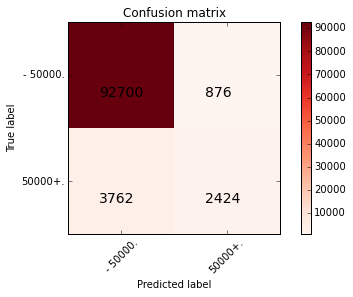

In [123]:
#Plot normalised confusion matrix
 
def plot_confusion_matrix(cm, title='Normalized confusion matrix', cmap=plt.cm.Blues):
    #Normalized the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    target_names=['- 50000.','50000+.']
    #rotation=45 represents the degree of rotation of the tick label
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    for i, cases in enumerate(cm):
        for j, case in enumerate(cases):
            if case>0:
                plt.text(j-.2, i+.2, case, fontsize=14)
    plt.show()

cm=metrics.confusion_matrix(y_test, y_prediction)
plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds)

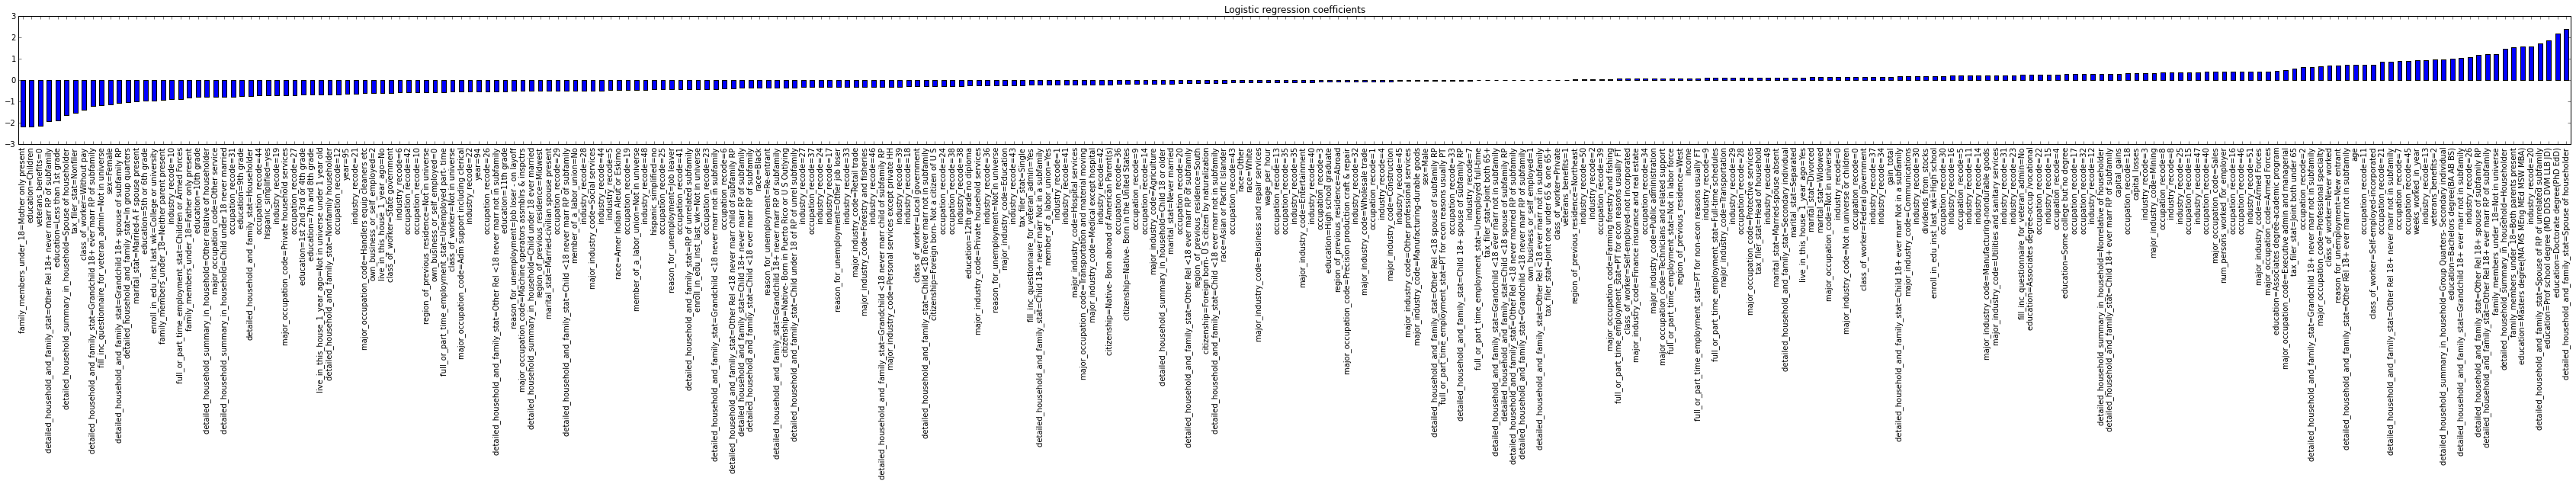

In [124]:
#Display coefficient of the log linear model
coefs = pd.Series(clf1.coef_[0], index=vec.get_feature_names())
coefs.sort()
coefs.plot(kind="bar",figsize=(60,3),title='Logistic regression coefficients')

In [30]:
#SVM classifier with RBF kernel
clf2 = svm.SVC(C=1.0, cache_size=3000, class_weight=None, coef0=0.0,
gamma=0.001, kernel='rbf', max_iter=-1, probability=False, random_state=None,
shrinking=True, tol=0.001, verbose=False)
clf2.fit(X_train, y_train)  
y_prediction2=clf2.predict(X_test)
score_svm=metrics.accuracy_score(y_test, y_prediction2)
score_svm

0.94785589703494322

In [ ]:
score_svm=metrics.accuracy_score(y_test, y_prediction2)
score_svm